本次以英雄联盟对局胜负预测任务为基础，要求实现决策树算法相关细节，加深对算法的理解，并了解做机器学习任务的大致流程。

### 任务介绍
英雄联盟（League of Legends，LoL）是一个多人在线竞技游戏，由拳头游戏（Riot Games）公司出品。在游戏中，每位玩家控制一位有独特技能的英雄，红蓝两支队伍各有五位玩家进行对战，目标是摧毁对方的基地水晶。水晶有多座防御塔保护，通常需要先摧毁一些防御塔再摧毁水晶。玩家所控制的英雄起初非常弱，需要不断击杀小兵、野怪和对方英雄来获得金币、经验。经验可以提升英雄等级和技能等级，金币可以用来购买装备提升攻击、防御等属性。对战过程中一般没有己方单位在附近的地点是没有视野的，即无法看到对面单位，双方可以通过使用守卫来监视某个地点，洞察对面走向、制定战术。
本数据集来自[Kaggle](https://www.kaggle.com/bobbyscience/league-of-legends-diamond-ranked-games-10-min)，包含了9879场钻一到大师段位的单双排对局，对局双方几乎是同一水平。每条数据是前10分钟的对局情况，每支队伍有19个特征，红蓝双方共38个特征。这些特征包括英雄击杀、死亡，金钱、经验、等级情况等等。一局游戏一般会持续30至40分钟，但是实际前10分钟的局面很大程度上影响了之后胜负的走向。作为最成功的电子竞技游戏之一，对局数据、选手数据的量化与研究具有重要意义，可以启发游戏将来的发展和改进。

本任务是希望同学们依据注释的要求，对代码中空缺部分进行填写，**完成决策树模型的详细实现**，根据已有的对局前10分钟特征信息，预测最后获胜方是蓝色方还是红色方，了解执行一个**机器学习任务的大致流程**，并**提交代码和实验报告**。第一次作业也是一个机器学习小实验的例子，之后的作业可能不再提供预处理等流程代码，由同学们自己设计实验完成代码编写。

### 导入工具包
pandas是数据分析和处理常用的工具包，非常适合处理行列表格数据。numpy是数学运算工具包，支持高效的矩阵、向量运算。sklearn是机器学习常用工具包，包括了一些已经实现好的简单模型和一些常用数据处理方法、评价指标等函数。

In [16]:
import pandas as pd # 数据处理
import numpy as np # 数学运算
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split, cross_validate  # 划分数据集函数
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score  # 准确率函数
import matplotlib.pyplot as plt  # 作图
import seaborn as sns  # 作图
from sklearn.decomposition import PCA
RANDOM_SEED = 2022 # 固定随机种子

# pd.set_option('display.width', 300)  # 设置字符显示宽度
pd.set_option('display.max_rows', 10)  # 设置显示最大行
# pd.set_option('display.max_columns', 50)  # 设置显示最大列，None为显示所有列
np.set_printoptions(threshold=10)


### 读入数据
假设数据文件放在`./data/`目录下，标准的csv文件可以用pandas里的`read_csv()`函数直接读入。文件共有40列，38个特征（红蓝方各19），1个标签列（blueWins），和一个对局标号（gameId）。对局标号不是标签也不是特征，可以舍去。

In [17]:
csv_data = './data/high_diamond_ranked_10min.csv' # 数据路径
data_df = pd.read_csv(csv_data, sep=',') # 读入csv文件为pandas的DataFrame
data_df = data_df.drop(columns='gameId') # 舍去对局标号列

###  数据概览
对于一个机器学习问题，在拿到任务和数据后，首先需要观察数据的情况，比如我们可以通过`.iloc[0]`取出数据的第一行并输出。不难看出每个特征都存成了float64浮点数，该对局蓝色方开局10分钟有小优势。同时也可以发现有些特征列是重复冗余的，比如blueGoldDiff表示蓝色队金币优势，redGoldDiff表示红色方金币优势，这两个特征是完全对称的互为相反数。blueCSPerMin是蓝色方每分钟击杀小兵数，它乘10就是10分钟所有小兵击杀数blueTotalMinionsKilled。在之后的特征处理过程中可以考虑去除这些冗余特征。
另外，pandas有非常方便的`describe()`函数，可以直接通过DataFrame进行调用，可以展示每一列数据的一些统计信息，对数据分布情况有大致了解，比如blueKills蓝色方击杀英雄数在前十分钟的平均数是6.14、方差为2.93，中位数是6，百分之五十以上的对局中该特征在4-8之间，等等。

In [18]:
# print(data_df.iloc[0]) # 输出第一行数据
data_df.describe()  # 每列特征的简单统计信息


,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
count,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,...,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000
mean,0.499038,22.288288,2.824881,0.504808,6.183925,6.137666,6.645106,0.549954,0.361980,0.187974,...,0.043021,16489.041401,6.925316,17961.730438,217.349226,51.313088,-14.414111,33.620306,21.734923,1648.904140
std,0.500024,18.019177,2.174998,0.500002,3.011028,2.933818,4.064520,0.625527,0.480597,0.390712,...,0.216900,1490.888406,0.305311,1198.583912,21.911668,10.027885,2453.349179,1920.370438,2.191167,149.088841
min,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,11212.000000,4.800000,10465.000000,107.000000,4.000000,-11467.000000,-8348.000000,10.700000,1121.200000
25%,0.000000,14.000000,1.000000,0.000000,4.000000,4.000000,4.000000,0.000000,0.000000,0.000000,...,0.000000,15427.500000,6.800000,17209.500000,203.000000,44.000000,-1596.000000,-1212.000000,20.300000,1542.750000
50%,0.000000,16.000000,3.000000,1.000000,6.000000,6.000000,6.000000,0.000000,0.000000,0.000000,...,0.000000,16378.000000,7.000000,17974.000000,218.000000,51.000000,-14.000000,28.000000,21.800000,1637.800000
75%,1.000000,20.000000,4.000000,1.000000,8.000000,8.000000,9.000000,1.000000,1.000000,0.000000,...,0.000000,17418.500000,7.200000,18764.500000,233.000000,57.000000,1585.500000,1290.500000,23.300000,1741.850000
max,1.000000,250.000000,27.000000,1.000000,22.000000,22.000000,29.000000,2.000000,1.000000,1.000000,...,2.000000,22732.000000,8.200000,22269.000000,289.000000,92.000000,10830.000000,9333.000000,28.900000,2273.200000


### 增删特征
传统的机器学习模型大部分都是基于特征的，因此特征工程是机器学习中非常重要的一步。有时构造一个好的特征比改进一个模型带来的提升更大。这里简单展示一些特征处理的例子。首先，上面提到，特征列中有些特征信息是完全冗余的，会给模型带来不必要的计算量，可以去除。其次，相比于红蓝双方击杀、助攻的绝对值，可能双方击杀英雄的差值更能体现出当前对战的局势。因此，我们可以构造红蓝双方对应特征的差值。数据文件中已有的差值是金币差GoldDiff和经验差ExperienceDiff，实际上每个对应特征都可以构造这样的差值特征。

In [19]:
# 部分数据有效性检验
print(data_df.columns)
print(data_df[(data_df['blueWardsDestroyed'] > data_df['redWardsPlaced'])
              | (data_df['blueWardsPlaced'] < data_df['redWardsDestroyed'] )
              | (data_df['blueDeaths'] != data_df['redKills']) | (data_df['blueKills'] != data_df['redDeaths'])])


Index(['blueWins', 'blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood',
       'blueKills', 'blueDeaths', 'blueAssists', 'blueEliteMonsters',
       'blueDragons', 'blueHeralds', 'blueTowersDestroyed', 'blueTotalGold',
       'blueAvgLevel', 'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin', 'redWardsPlaced', 'redWardsDestroyed',
       'redFirstBlood', 'redKills', 'redDeaths', 'redAssists',
       'redEliteMonsters', 'redDragons', 'redHeralds', 'redTowersDestroyed',
       'redTotalGold', 'redAvgLevel', 'redTotalExperience',
       'redTotalMinionsKilled', 'redTotalJungleMinionsKilled', 'redGoldDiff',
       'redExperienceDiff', 'redCSPerMin', 'redGoldPerMin'],
      dtype='object')
Empty DataFrame
Columns: [blueWins, blueWardsPlaced, blueWardsDestroyed, blueFirstBlood, blueKills, blueDeaths, blueAssists, blueEliteMonsters, blueDragons, blueHeralds, blueTowersDestr

In [20]:
# 只保留差值的增删特征
drop_features = ['blueGoldDiff', 'redGoldDiff',
                 'blueExperienceDiff', 'redExperienceDiff',
                 'blueCSPerMin', 'redCSPerMin',
                 'blueGoldPerMin', 'redGoldPerMin', 'blueFirstBlood', 'redFirstBlood']  
                 # 需要舍去的无用特征列
df = data_df.drop(columns=drop_features)  # 舍去特征列
info_names = [c[3:]
              for c in df.columns if c.startswith('red')]  # 取出要作差值的特征名字（除去red前缀）
for info in info_names:  # 对于每个特征名字
    df['br' + info] = df['blue' + info] - df['red' + info]  # 构造一个新的特征，由蓝色特征减去红色特征，前缀为br
    df = df.drop(columns=['blue' + info, 'red' + info])     # 保留差值
df[df['blueWins']>=1].describe()
df.describe()


,blueWins,brWardsPlaced,brWardsDestroyed,brKills,brDeaths,brAssists,brEliteMonsters,brDragons,brHeralds,brTowersDestroyed,brTotalGold,brAvgLevel,brTotalExperience,brTotalMinionsKilled,brTotalJungleMinionsKilled
count,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000
mean,0.499038,-0.079664,0.101731,0.046260,-0.046260,-0.017006,-0.023180,-0.051119,0.027938,0.008402,14.414111,-0.009313,-33.620306,-0.649661,-0.803421
std,0.500024,25.960582,2.854910,4.195489,4.195489,5.766787,1.067934,0.878945,0.589292,0.324835,2453.349179,0.478434,1920.370438,30.942675,14.274733
min,0.000000,-260.000000,-23.000000,-17.000000,-16.000000,-25.000000,-2.000000,-1.000000,-1.000000,-2.000000,-10830.000000,-2.600000,-9333.000000,-120.000000,-72.000000
25%,0.000000,-4.000000,-1.000000,-3.000000,-3.000000,-4.000000,-1.000000,-1.000000,0.000000,0.000000,-1585.500000,-0.400000,-1290.500000,-21.000000,-10.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,-28.000000,-1.000000,0.000000
75%,1.000000,4.000000,1.000000,3.000000,3.000000,4.000000,1.000000,1.000000,0.000000,0.000000,1596.000000,0.200000,1212.000000,20.000000,8.000000
max,1.000000,234.000000,23.000000,16.000000,17.000000,23.000000,2.000000,1.000000,1.000000,4.000000,11467.000000,2.400000,8348.000000,127.000000,64.000000


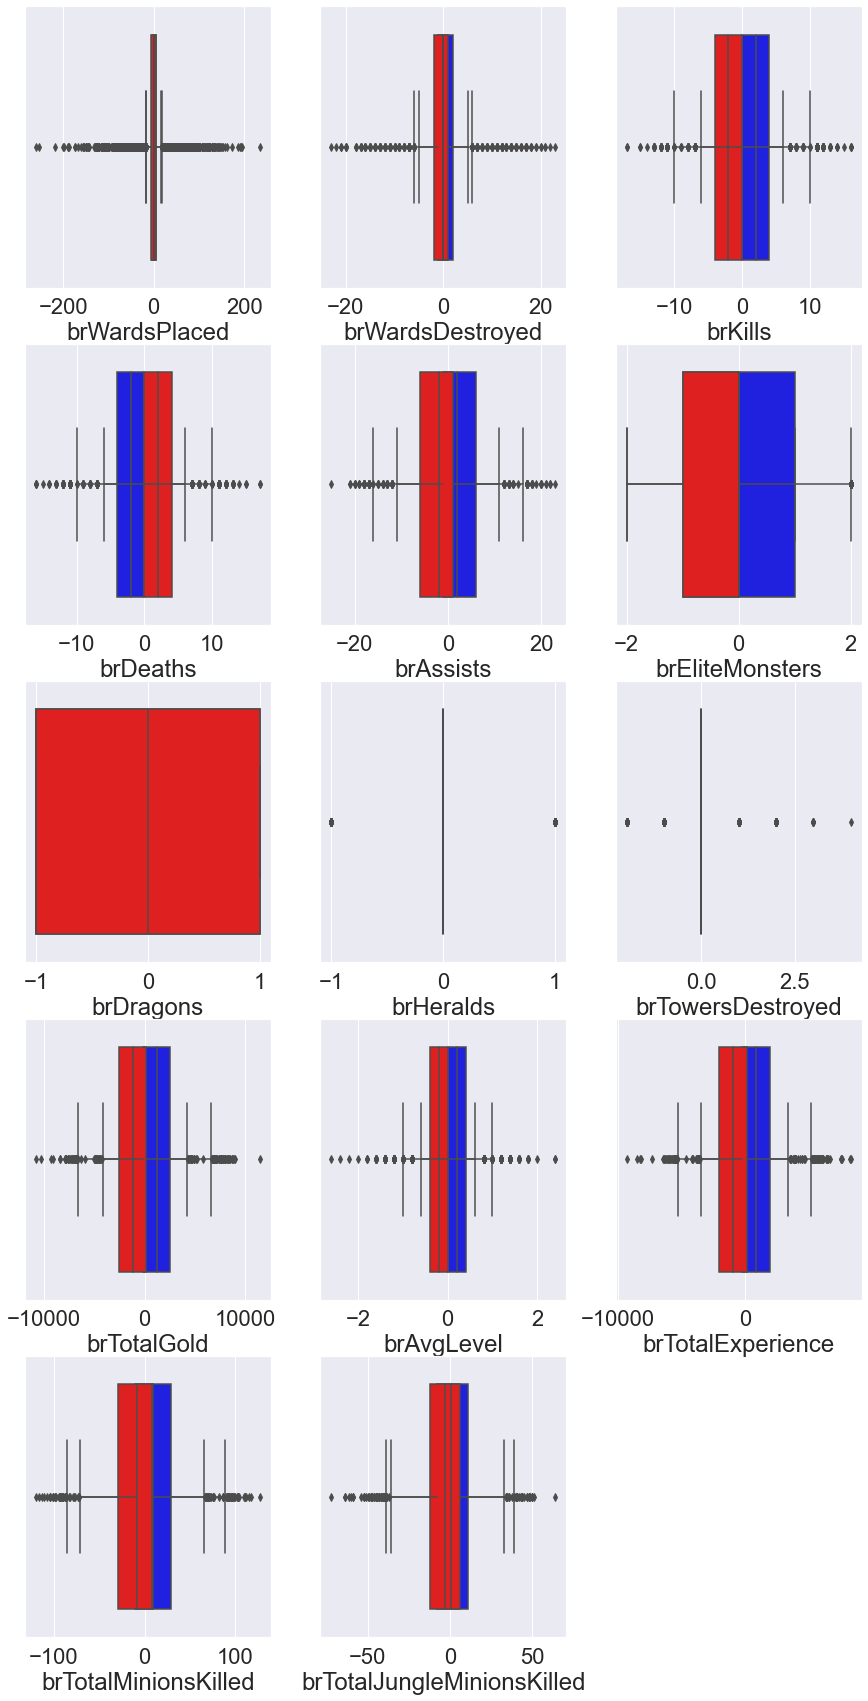

In [21]:
plt.figure(figsize=(15,30))
pos = 1
sns.set(font_scale=2)
for i in df[df['blueWins'] >= 1].columns[1:]:
    plt.subplot(5, 3, pos)
    sns.boxplot(x=df[df['blueWins'] >= 1][i],color='blue')
    sns.boxplot(x=df[df['blueWins'] < 1][i],color='red')
    pos += 1


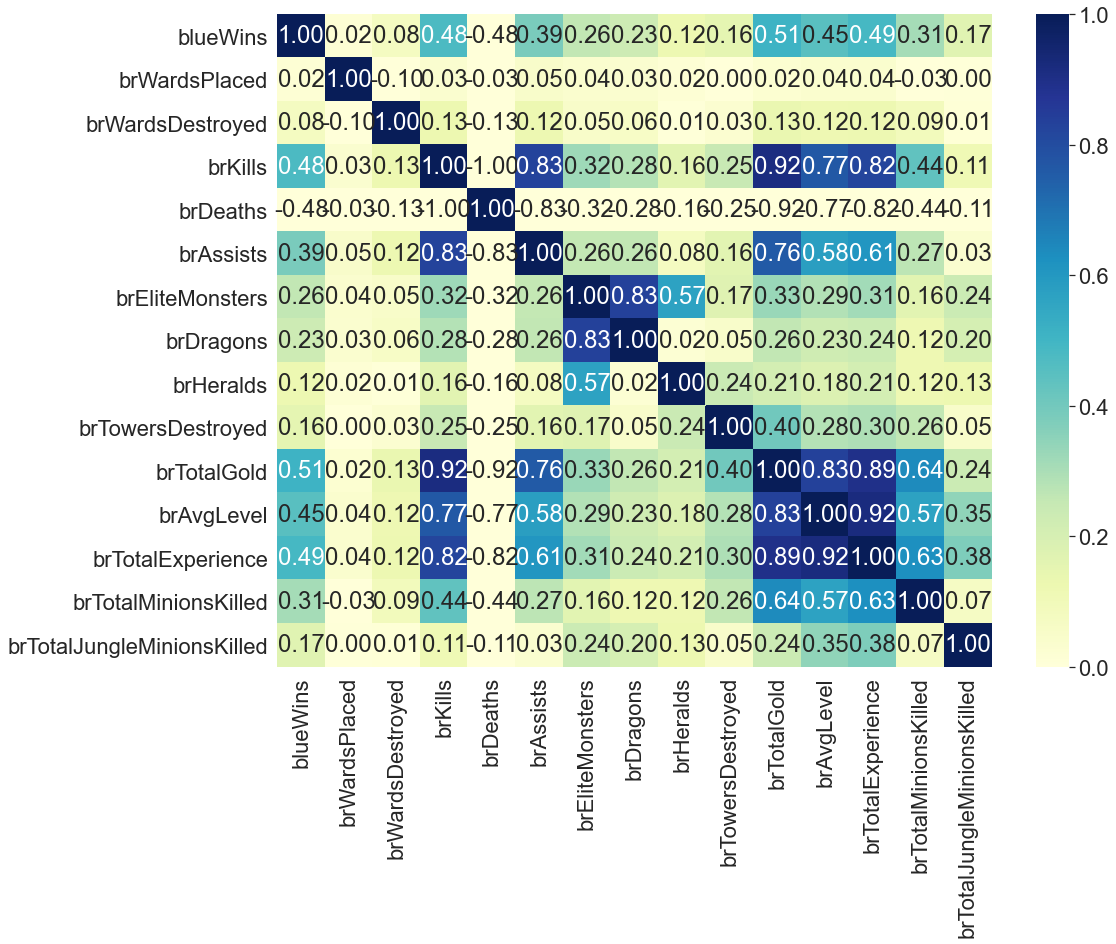

In [22]:
# 特征提取，根据数据相关性进行降维
plt.figure(figsize=(16, 12))  # 设置图像大小
# 获得相关性矩阵，pandas的DataFrame有直接的函数，绘制热力图
corr_matrix = df[[c for c in df.columns]].corr()
cg = sns.heatmap(corr_matrix, cmap='YlGnBu', annot=True,
                 fmt='.2f', vmin=0)          


In [23]:
# 需要舍去的无用特征列
df = df.drop(columns=['brWardsDestroyed',
                      'brWardsPlaced', 'brTowersDestroyed', 'brTotalMinionsKilled', 'brHeralds'])
df.describe()

,blueWins,brKills,brDeaths,brAssists,brEliteMonsters,brDragons,brTotalGold,brAvgLevel,brTotalExperience,brTotalJungleMinionsKilled
count,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000
mean,0.499038,0.046260,-0.046260,-0.017006,-0.023180,-0.051119,14.414111,-0.009313,-33.620306,-0.803421
std,0.500024,4.195489,4.195489,5.766787,1.067934,0.878945,2453.349179,0.478434,1920.370438,14.274733
min,0.000000,-17.000000,-16.000000,-25.000000,-2.000000,-1.000000,-10830.000000,-2.600000,-9333.000000,-72.000000
25%,0.000000,-3.000000,-3.000000,-4.000000,-1.000000,-1.000000,-1585.500000,-0.400000,-1290.500000,-10.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,-28.000000,0.000000
75%,1.000000,3.000000,3.000000,4.000000,1.000000,1.000000,1596.000000,0.200000,1212.000000,8.000000
max,1.000000,16.000000,17.000000,23.000000,2.000000,1.000000,11467.000000,2.400000,8348.000000,64.000000


In [24]:
# 使用PCA提取主成分
def myPCA(n):
    pca = PCA(n_components=n)
    pca.fit(df.iloc[:, 1:])
    df = pd.concat([df['blueWins'], pd.DataFrame(
        pca.transform(df.iloc[:, 1:]))], axis=1)
    plt.figure(figsize=(16, 12))  # 设置图像大小

    # 获得相关性矩阵，pandas的DataFrame有直接的函数，绘制热力图
    corr_matrix = df[[c for c in df]].corr()
    cg = sns.heatmap(corr_matrix, cmap='YlGnBu', annot=True,
                    fmt='.2f', vmin=0)
# myPCA(6)


### 特征离散化
决策树ID3算法一般是基于离散特征的，本例中存在很多连续的数值特征，例如队伍金币。直接应用该算法每个值当作一个该特征的一个取值可能造成严重的过拟合，因此需要对特征进行离散化，即将一定范围内的值映射成一个值，例如对用户年龄特征，将0-10映射到0，11-18映射到1，19-25映射到2，25-30映射到3，等等类似，然后在决策树构建时使用映射后的值计算信息增益。

***本小节要求实现特征离散化，请补全相关代码***

In [25]:
discrete_df = df.copy()

def discrete_fea(dis_thre=10,method = 'qcut'):
    '''
    离散化每一列特征，即discrete_df[c] = ...
    dis_thre是对于有些特征本身取值就很少，可以跳过的阈值
    method是使用等区间(cut)或等密度(qcut)划分
    '''
    global df, discrete_df
    for c in df.columns[1:]:
        # 些特征本身取值就很少，可以跳过
        if len(set(discrete_df[c])) <= dis_thre:
            continue
        
        elif method=='cut':
            # 注释部分是通过划分两侧最大/小值进行分割，效果类似
            # division=[min(df[df['blueWins'] > 0][c])-0.5, max(df[df['blueWins'] > 0][c]+0.5),\
            #           min(df[df['blueWins'] < 1][c])-0.5, max(df[df['blueWins'] < 1][c])+0.5]
            # division = sorted(division)
            # division.append((division[2]-division[1])//3+division[1])
            # division.append(division[2]-(division[2]-division[1])//3)
            # discrete_df[c] = pd.cut(df[c], sorted(division))
            discrete_df[c] = pd.cut(df[c], dis_thre, labels=[i for i in range(dis_thre)])
        else:
            discrete_df[c] = pd.qcut(
                df[c], dis_thre, precision=0, labels=False, duplicates='drop')

discrete_fea(3, 'qcut')


### 数据集准备
构建机器学习模型前要构建训练和测试的数据集。在本例中首先需要分开标签和特征，标签是不能作为模型的输入特征的，就好比作业和试卷答案不能在做题和考试前就告诉学生。测试一个模型在一个任务上的效果至少需要训练集和测试集，训练集用来训练模型的参数，好比学生做作业获得知识，测试集用来测试模型效果，好比期末考试考察学生学习情况。测试集的样本不应该出现在训练集中，否则会造成模型效果估计偏高，好比考试时出的题如果是作业题中出现过的，会造成考试分数不能准确衡量学生的学习情况，估计值偏高。划分训练集和测试集有多种方法，下面首先介绍的是随机取一部分如20%作测试集，剩下作训练集。sklearn提供了相关工具函数`train_test_split`。sklearn的输入输出一般为numpy的array矩阵，需要先将pandas的DataFrame取出为numpy的array矩阵。

In [26]:
all_y = discrete_df['blueWins'].values  # 所有标签数据
feature_names = discrete_df.columns[1:] # 所有特征的名称
all_x = discrete_df[feature_names].values # 所有原始特征值，pandas的DataFrame.values取出为numpy的array矩阵
# 划分训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(all_x, all_y, test_size=0.2, random_state=RANDOM_SEED)
all_y.shape, all_x.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape # 输出数据行列信息


((9879,), (9879, 9), (7903, 9), (1976, 9), (7903,), (1976,))

###  决策树模型的实现
***本小节要求实现决策树模型，请补全算法代码***

In [32]:
# 定义决策树类
class DecisionTree(object):
    def __init__(self, classes, features,
                 max_depth=10, min_samples_split=10,
                 impurity_t='entropy'):
        '''
        传入一些可能用到的模型参数
        classes表示模型分类总共有几类
        features是每个特征的名字，也方便查询总的共特征数
        max_depth表示构建决策树时的最大深度
        min_samples_split表示构建决策树分裂节点时，如果到达该节点的样本数小于该值则不再分裂
        impurity_t表示计算混杂度（不纯度）的计算方式，例如entropy或gini
        '''
        self.classes = classes
        self.features = features
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.impurity_t = impurity_t
        self.root = None  # 定义根节点，未训练时为空
        self.tree = defaultdict(list)

    # 要调用sklearn的cross_validate需要实现该函数返回所有参数
    def get_params(self, deep):
        return {'classes': self.classes, 'features': self.features,
                'max_depth': self.max_depth, 'min_samples_split': self.min_samples_split,
                'impurity_t': self.impurity_t}

    # 要调用sklearn的GridSearchCV需要实现该函数给类设定所有参数
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def impurity(self, label):
        '''
        计算不纯度，根据传入参数计算信息熵或gini系数
        label是numpy一维数组：根据当前特征划分后的标签组成
        '''
        cnt, total = Counter(label), float(len(label))
        probs = [cnt[v]/total for v in cnt]
        if self.impurity_t == 'gini':
            return 1 - sum([p*p for p in probs])
        return -sum([p * np.log2(p) for p in probs if p > 0])

    def gain(self, feature, label) -> tuple:
        '''
        计算某个结点对应不同特征信息增益
        feature是numpy一维数组：当前待分结点某个特征的值，
        label是numpy一维数组：对应的标签

        返回元组：
            信息增益率，以及一个分类字典f_index{特征值：数组下标}，以供获取子节点使用
        '''
        # 未分裂前的混杂度，仅仅根据标签计算
        p_impurity = self.impurity(label)

        # 记录特征的每种取值所对应的样本下标
        f_index = defaultdict(list)
        for idx, v in enumerate(feature):
            f_index[v].append(idx)

        # 根据该特征分裂后的不纯度，与特征的每种值的数目加权和
        c_impurity = 0
        for v in f_index:
            f_l = label[f_index[v]]
            c_impurity += self.impurity(f_l) * len(f_l)/len(label)

        # 计算信息增益率，即在标签无关时的不纯度
        # 防止对特征取值多的天然偏执，防止过拟合
        r = self.impurity(feature)
        r = (p_impurity - c_impurity) / (r if r != 0 else 1)
        return r, f_index

    def expand_node(self, feature, label, depth, used_features) -> tuple:
        '''
        训练时递归函数分裂节点，考虑不同情况。最后返回该函数返回根节点。
        feature为二维numpy（n*m）数组，每行表示一个样本，有m个特征
        label为一维numpy（n）数组，表示每个样本的分类标签
        depth记录了当前节点的深度
        used_features表示已经用过的特征，不再重复使用

        返回：
            if到叶结点，返回当前类别
            if未到叶结点，返回一个元组（特征下标，特征取值和对应的子节点，
                                            到达当前节点的样本中最多的类别）
        '''

        # 1. 递归终止条件：只有一种类别无需分裂 或 达到分裂阈值，返回叶结点
        if len(set(label)) == 0:
            return label[0]
        most = Counter(label).most_common(1)[0][0]
        if depth > self.max_depth or len(label) < self.min_samples_split:
            return most

        # 2. 遍历所有未使用特征，调用gain()找到最佳分裂特征
        bestf, max_gain, bestf_idx = -1, -1, None
        for f in range(len(self.features)):
            if f in used_features:
                continue
            # 计算该特征的信息增益，和每个取值的样本下标
            f_gain, f_idx = self.gain(feature[:, f], label)
            if bestf < 0 or f_gain > max_gain:
                bestf, max_gain, bestf_idx = f, f_gain, f_idx

        # 3. 如果找不到有用的分裂特征，也结束递归
        if bestf < 0:
            return most

        # 4. 遍历特征的每种取值，递归调用expand_node进行建树，decision{特征取值：子结点}
        children = {}
        new_used_features = used_features+[bestf]
        for v in bestf_idx:
            c_idx = bestf_idx[v]
            children[v] = self.expand_node(feature[c_idx, :], \
                                label[c_idx], depth + 1, new_used_features)
        self.tree[depth].append(self.features[bestf])
        return (bestf, children, most)

    def traverse_node(self, node, feature):
        # 要求输入样本特征数和模型定义时特征数目一致
        assert len(self.features) == len(feature) 
        '''
        traverse_node()预测时遍历节点，根据特征路由，考虑不同情况
        node表示当前到达的节点，例如最开始取根节点self.root
        feature是长度为m的numpy一维数组，一个样本的所有特征
        '''
        # 已经到达叶节点，则返回分类结果
        if type(node) is not tuple:
            return node
        # 依据特征取值进入相应子节点，递归调用traverse_node，node[0]记录了特征的下标.
        fv = feature[node[0]]
        if fv in node[1]:
            return self.traverse_node(node[1][fv], feature)
        # 该特征取值在训练集中未出现过，返回训练时到达当前节点的样本中最多的类别
        return node[-1]

    def fit(self, feature, label):
        assert len(self.features) == len(
            feature[0])  # 输入数据的特征数目应该和模型定义时的特征数目相同
        '''
        训练模型
        feature为二维numpy（n*m）数组，每行表示一个样本，有m个特征
        label为一维numpy（n）数组，表示每个样本的分类标签
        '''
        # 从根节点开始分裂，模型记录根节点
        self.root = self.expand_node(
            feature, label, depth=1, used_features=[])

    def predict(self, feature):
        assert len(feature.shape) == 1 or len(feature.shape) == 2  # 只能是1维或2维
        '''
        预测
        输入feature可以是一个一维numpy数组也可以是一个二维numpy数组
        如果是一维numpy（m）数组，则是一个样本，包含m个特征，返回一个类别值
        如果是二维numpy（n*m）数组，则表示n个样本，每个样本包含m个特征，返回一个numpy一维数组
        '''
        if len(feature.shape) == 1:  # 如果是一个样本
            return self.traverse_node(self.root, feature)  # 从根节点开始路由
        # 如果是很多个样本
        return np.array([self.traverse_node(self.root, f) for f in feature])


# 定义决策树模型，传入算法参数
DT = DecisionTree(classes=[0, 1], features=feature_names,
                  max_depth=3, min_samples_split=450, impurity_t='gini')

DT.fit(x_train, y_train)  # 在训练集上训练
p_test = DT.predict(x_test)  # 在测试集上预测，获得预测值
print('pred_value ',p_test)  # 输出预测值
print('true_value ',y_test)
test_acc = accuracy_score(y_test, p_test)  # 将测试预测值与测试集标签对比获得准确率
precision = precision_score(y_test, p_test)
recall = recall_score(y_test, p_test)
f1 = f1_score(y_test, p_test)
print('\nTREE:')
for _ in DT.tree.keys():
    print('Layer'+str(_)+':'+str(DT.tree[_]))
print('\naccuracy: {:.4f}   precision: {:.4f}   recall: {:.4f}   f1_score: {:.4f}'.format(
    test_acc, precision, recall, f1))  # 输出准确率


pred_value  [0 0 0 ... 1 0 0]
true_value  [0 1 1 ... 0 0 0]

TREE:
Layer3:['brAvgLevel', 'brDragons', 'brKills', 'brDragons', 'brDragons', 'brEliteMonsters']
Layer2:['brKills', 'brTotalExperience', 'brTotalExperience']
Layer1:['brTotalGold']

accuracy: 0.7414   precision: 0.7342   recall: 0.7226   f1_score: 0.7283


### 模型调优
第一次模型测试结果可能不够好，可以先检查调试代码是否有bug，再尝试调整参数或者优化计算方法。

In [12]:
# 使用5折交叉验证调整参数
best = None
min_samples_split=1
best_depth = 0
for impurity_t in ['entropy', 'gini']:
    accuracys=[]
    # 遍历最大树深度
    for max_depth in range(1, 11):
        DT = DecisionTree(classes=[0, 1], features=feature_names,
                            max_depth=max_depth, min_samples_split=min_samples_split, impurity_t=impurity_t)
        cv_result = cross_validate(
            DT, all_x, all_y, scoring=('accuracy'), cv=5)
        test_acc = np.mean(cv_result['test_score']) 
        current = (test_acc, max_depth, min_samples_split,
                    impurity_t)
        accuracys.append(current[0])
        if best is None or test_acc > best[0]: 
            best = current
            best_depth = max_depth
            print('better accuracy: {:.4f}, max_depth={}, min_samples_split={}, impurity_t={}'.format(
                *best))
            
        else:
            print('accuracy: {:.4f}, max_depth={}, min_samples_split={}, impurity_t={}'.format(
                *current))
    print(accuracys)


better accuracy: 0.7009, max_depth=1, min_samples_split=1, impurity_t=entropy
better accuracy: 0.7127, max_depth=2, min_samples_split=1, impurity_t=entropy
better accuracy: 0.7306, max_depth=3, min_samples_split=1, impurity_t=entropy
accuracy: 0.7286, max_depth=4, min_samples_split=1, impurity_t=entropy
accuracy: 0.7243, max_depth=5, min_samples_split=1, impurity_t=entropy
accuracy: 0.7157, max_depth=6, min_samples_split=1, impurity_t=entropy
accuracy: 0.7126, max_depth=7, min_samples_split=1, impurity_t=entropy
accuracy: 0.7071, max_depth=8, min_samples_split=1, impurity_t=entropy
accuracy: 0.7024, max_depth=9, min_samples_split=1, impurity_t=entropy
accuracy: 0.7024, max_depth=10, min_samples_split=1, impurity_t=entropy
[0.7008805924255623, 0.7127237226464408, 0.7306399323527903, 0.7286156921027007, 0.7242637216214831, 0.715659509045252, 0.712622559319428, 0.7070552964690207, 0.7023993747757904, 0.7023993747757904]
accuracy: 0.7009, max_depth=1, min_samples_split=1, impurity_t=gini
a

In [16]:
best = None
max_depth = best_depth
for impurity_t in ['entropy', 'gini']:
    accuracys=[]
    # 遍历节点分裂最小样本数的阈值
    for min_samples_split in range(50, 800, 50):
        DT = DecisionTree(classes=[0, 1], features=feature_names,
                            max_depth=max_depth, min_samples_split=min_samples_split, impurity_t=impurity_t)
        cv_result = cross_validate(
            DT, all_x, all_y, scoring=('accuracy'), cv=5)
        test_acc = np.mean(cv_result['test_score']) 
        current = (test_acc, max_depth, min_samples_split,
                    impurity_t)
        accuracys.append(current[0])
        if best is None or test_acc > best[0]: 
            best = current  # 记录最好结果
            print('better accuracy: {:.4f}, max_depth={}, min_samples_split={}, impurity_t={}'.format(
                *best))  # 输出准确率和参数
            
        else:
            print('accuracy: {:.4f}, max_depth={}, min_samples_split={}, impurity_t={}'.format(
                *current))  # 输出准确率和参数
    print(accuracys)


better accuracy: 0.6922, max_depth=3, min_samples_split=50, impurity_t=entropy
better accuracy: 0.6988, max_depth=3, min_samples_split=100, impurity_t=entropy
better accuracy: 0.7139, max_depth=3, min_samples_split=150, impurity_t=entropy
better accuracy: 0.7150, max_depth=3, min_samples_split=200, impurity_t=entropy
better accuracy: 0.7151, max_depth=3, min_samples_split=250, impurity_t=entropy
better accuracy: 0.7153, max_depth=3, min_samples_split=300, impurity_t=entropy
accuracy: 0.7153, max_depth=3, min_samples_split=350, impurity_t=entropy
better accuracy: 0.7174, max_depth=3, min_samples_split=400, impurity_t=entropy
accuracy: 0.7159, max_depth=3, min_samples_split=450, impurity_t=entropy
accuracy: 0.7159, max_depth=3, min_samples_split=500, impurity_t=entropy
accuracy: 0.7159, max_depth=3, min_samples_split=550, impurity_t=entropy
accuracy: 0.7161, max_depth=3, min_samples_split=600, impurity_t=entropy
accuracy: 0.7161, max_depth=3, min_samples_split=650, impurity_t=entropy
acc

Text(0, 0.5, 'accurancy')

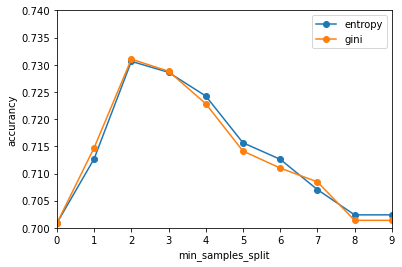

In [39]:
# 准确率随着参数变化，折线图的绘制
from matplotlib import pyplot
import matplotlib.pyplot as plt
 
 
y_1 = [0.7008805924255623, 0.7127237226464408, 0.7306399323527903, 0.7286156921027007, 0.7242637216214831,
       0.715659509045252, 0.712622559319428, 0.7070552964690207, 0.7023993747757904, 0.7023993747757904]
x = range(len(y_1))
y_2 = [0.7008805924255623, 0.714749039102137, 0.7310449956439297, 0.7288182749961565, 0.7228465638292421,
       0.7141406241992517, 0.7110029723773894, 0.7084719930302874, 0.7013867165479424, 0.7013867165479424]
#plt.plot(x, y, 'ro-')
#plt.plot(x, y1, 'bo-')
#pl.xlim(-1, 11)  # 限定横轴的范围
plt.ylim(0.70, 0.74)  # 限定纵轴的范围
 
 
plt.plot(x, y_1, marker='o', label='entropy')
plt.plot(x, y_2, marker='o', label='gini')
plt.legend()  # 让图例生效
 
plt.margins(0)
# plt.subplots_adjust(bottom=0.10)
plt.xlabel('min_samples_split')  # X轴标签
plt.ylabel("accurancy") #Y轴标签
#plt.title("A simple plot") #标题


In [594]:
# 使用sklearn封装好的决策树，寻找优化上界
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

parameters = {
    'splitter': ('best', 'random'),
    'criterion': ('gini', 'entropy'),
    'max_depth': [*range(1, 20, 2)],
}

clf = DecisionTreeClassifier(random_state=0)
GS = GridSearchCV(clf, parameters, cv=10)
GS.fit(x_train, y_train)
GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'splitter': ('best', 'random')})
# 输出最佳得分
print("best score: ", GS.best_score_)
print("best param: ", GS.best_params_)


best score:  0.7282080046088112
best param:  {'criterion': 'entropy', 'max_depth': 5, 'splitter': 'best'}


In [13]:
# 最佳模型
best_clf = DecisionTreeClassifier(
    criterion="gini", max_depth=7, splitter="best")
best_clf.fit(x_train, y_train)
print("score:", best_clf.score(x_test, y_test))
# 输出分类报告
y_pred = best_clf.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print('Classification report : \n', cr)


NameError: name 'DecisionTreeClassifier' is not defined

### 总结
一个完整的机器学习任务包括：确定任务、数据分析、特征工程、数据集划分、模型设计、模型训练和效果测试、结果分析和调优等多个阶段，本案例以英雄联盟游戏胜负预测任务为例，给出了每个阶段的一些简单例子，帮助大家入门机器学习，希望大家有所收获！